In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.utils import to_categorical
# from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
# from keras import backend as objectives
from tensorflow.keras.losses import mse, binary_crossentropy
import skimage as sk
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import skimage
from skimage import io 
import os
from pathlib import Path
import cv2 as cv2
from tensorflow.python.framework.ops import disable_eager_execution
from PIL import Image 
import pandas as pd

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
# For custom loss functions
disable_eager_execution()

In [3]:
# This collection of the files is for random split in train and test

file_path = r"C:\Users\Saaqib\Documents\Imperial\Research Project\SWET_data"
img_path = []

files = os.listdir(file_path)
for root, directories, files in os.walk(file_path, topdown=False):
	for name in files:
		img_path.append(os.path.join(root, name))

In [4]:
df = pd.read_csv(r"C:\Users\Saaqib\Documents\Imperial\Research Project\Coding\image_quality.csv")
df.head()

ref_id Eczema-Evaluability Evaluability-reason  \
0  01001_wk00_1.jpg     Low (Difficult)    ['Out-of-focus']   
1  01001_wk00_2.jpg     Low (Difficult)   ['Other reasons']   
2  01001_wk04_1.jpg     Low (Difficult)   ['Other reasons']   
3  01001_wk04_2.jpg       Normal (Fine)                 NaN   
4  01001_wk12_1.jpg       Normal (Fine)                 NaN   

                                  Clinician-comments 100% AD  out-of-focus  \
0                                                NaN     NaN             1   
1  image very grainy. The marks on the thumb are ...     NaN             0   
2                                                NaN     NaN             0   
3                                                NaN     NaN             0   
4                                                NaN     NaN             0   

   overexposed  multiple-person  multiple-skin  skin-ratio  brightness  \
0            0                0              0           0           0   
1            0                1              0           0           0   
2            0                0              0           0           0   
3            0                0              0           0           0   
4            0                0              0           0           0   

   mask_ratio  quality_score  
0   65.891647              1  
1   26.543037              1  
2   81.855388              0  
3   68.787315              0  
4   38.040559              0

In [5]:
img_path[1]

'C:\\Users\\Saaqib\\Documents\\Imperial\\Research Project\\SWET_data\\01001\\wk00_2.jpg'

In [6]:
# Get the ref_id from the files to compare to the df
file_name = []
for i in img_path:
    a = i.split("\\")
    file_name.append(a[7] + "_" + a[8])

In [7]:
# See which images are not there in df but are in img_path
ref = df["ref_id"].tolist()

difference_1 = set(file_name).difference(set(ref))
difference_2 = set(ref).difference(set(file_name))

list_difference = list(difference_1.union(difference_2))
print(list_difference)


['01047_wk04_3.jpg', '01040_wk16_5.jpg', '01040_wk16_4.jpg', '01068_wk12_2JPG', '01040_wk16_3.jpg']


In [8]:
# Remove those images not in df from img_path (5 images)
#?????? Do i need this

for i in list_difference:
    a = i.split("_")
    removal_imgs = "C:\\Users\\Saaqib\\Documents\\Imperial\\Research Project\\SWET_data\\" + a[0] + "\\" + a[1] + "_" + a[2]
    img_path.remove(removal_imgs)


In [9]:
# Splitting data into train and test
train = []
test = []
for i, j, evall in zip(range(len(df)), df["ref_id"], df["Eczema-Evaluability"]):
    if evall == "Normal (Fine)" or evall == "High (Great)":
        train.append(j)
    else:
        test.append(j)

In [10]:
# Edit train and test arrays so that they can be read

for i, j, k, l in zip(train,test, range(len(train)),range(len(test))):
    a = i.split("_",1)
    b = j.split("_",1)
    train[k] = "C:\\Users\\Saaqib\\Documents\\Imperial\\Research Project\\SWET_data\\" + a[0] + "\\" + a[1]
    test[l] = "C:\\Users\\Saaqib\\Documents\\Imperial\\Research Project\\SWET_data\\" + b[0] + "\\" + b[1]

In [11]:
# data generator

def get_input(path):
    """get specific image from path"""
    
    img = io.imread(path)
    return img

# def preprocess_input(img):
#     # convert between 0 and 1
#     return img.astype('float32')

In [12]:
# Here do the same as the cell below - read test and train
train_set = []
test_set = []
for tra, tes in zip(train[0:20], test[0:20]):
    tra_inputs = get_input(tra)
    tes_inputs = get_input(tes)
    # inputs = skimage.color.rgb2gray(inputs)
    tra_inputs = cv2.resize(tra_inputs,(768,512))
    tes_inputs = cv2.resize(tes_inputs,(768,512))
    # inputs = cv2.cvtColor(inputs, cv2.COLOR_RGB2BGR)
    # inputs = preprocess_input(inputs)
    # inputs.astype('float32') / 255.0 -~ 0.5
    train_set.append(tra_inputs)
    test_set.append(tes_inputs)
train_set = np.array(train_set)
test_set = np.array(test_set)

In [46]:
# # After the custom split I don't think I need to do this 
# for file_path in img_path[0:20]:
#     inputs = get_input(file_path)
#     # inputs = skimage.color.rgb2gray(inputs)
#     inputs = cv2.resize(inputs,(768,512))
#     # inputs = cv2.cvtColor(inputs, cv2.COLOR_RGB2BGR)
#     # inputs = preprocess_input(inputs)
#     # inputs.astype('float32') / 255.0 -~ 0.5
#     x.append(inputs)
#     y.append(inputs)
# x = np.array(x)
# y = np.array(y)

In [22]:
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# x_train = x_train.reshape(-1,512,768,3)
# x_test = x_test.reshape(-1,512,768,3)
# y_train = x_train.reshape(-1,512,768,3)
# y_test = x_test.reshape(-1,512,768,3)

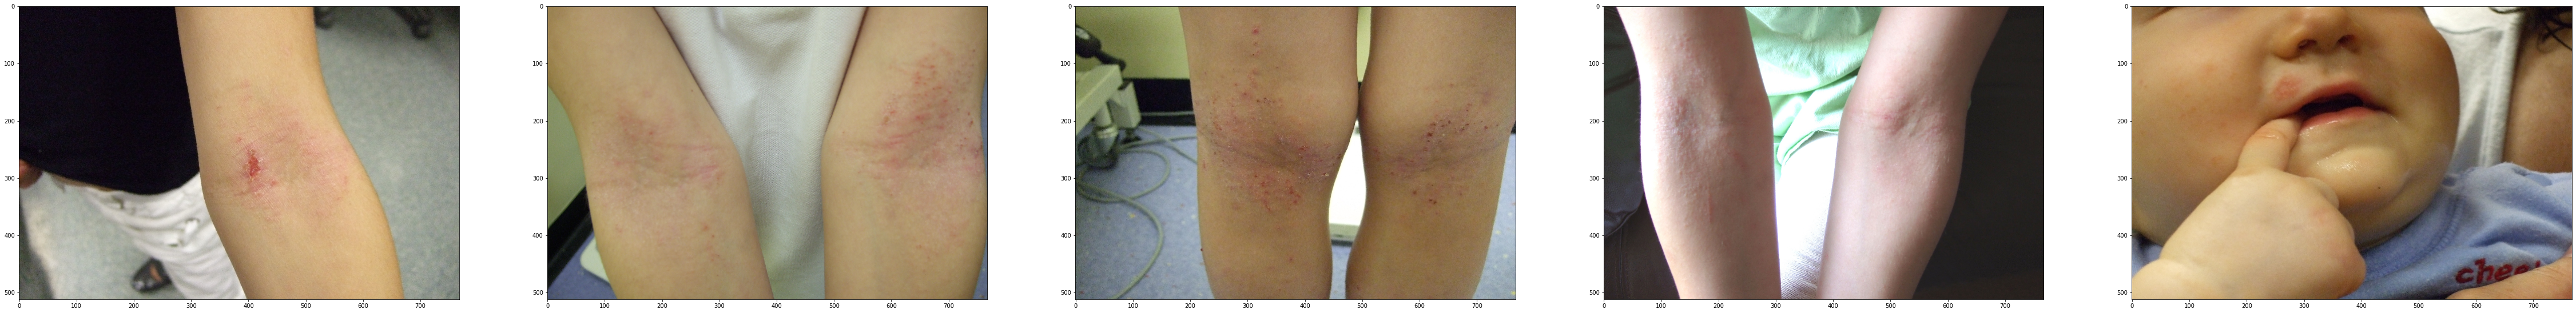

In [13]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(train_set[i])

In [14]:
b_size = 16
n_size = 128
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape = (n_size,) , mean = 0, stddev = 1)
    return z_mean + K.exp(z_log_sigma/2) * epsilon
  
def build_conv_vae(input_shape, bottleneck_size, sampling, batch_size = 16):
    
    # ENCODER
    inputt = Input(shape=(input_shape[0],input_shape[1],input_shape[2]))
    x = Conv2D(32,(3,3),activation = 'relu', padding = 'same')(inputt)    
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(64,(3,3),activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(64,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    latent_view = MaxPooling2D((2,2), padding ='same')(x)
    
    # Latent Variable Calculation
    shape = K.int_shape(latent_view)
    
    flatten_1 = Flatten()(latent_view)
    dense_1 = Dense(bottleneck_size, name='z_mean')(flatten_1)
    z_mean = BatchNormalization()(dense_1)

    flatten_2 = Flatten()(latent_view)
    dense_2 = Dense(bottleneck_size, name ='z_log_sigma')(flatten_2)
    z_log_sigma = BatchNormalization()(dense_2)

    z = Lambda(sampling)([z_mean, z_log_sigma])
    encoder = Model(inputt, [z_mean, z_log_sigma, z], name = 'encoder')
    
    # DECODER
    latent_input = Input(shape=(bottleneck_size,), name = 'decoder_input')
    x = Dense(shape[1]*shape[2]*shape[3])(latent_input)
    x = Reshape((shape[1],shape[2],shape[3]))(x)
    x = UpSampling2D((2,2))(x)
    # x = Cropping2D([[0,0],[0,1]])(x)
    x = Conv2DTranspose(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    # x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(64,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    # x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(64,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    output = Conv2DTranspose(3,(3,3), activation = 'tanh', padding ='same')(x)

    decoder = Model(latent_input, output, name = 'decoder')

    output_2 = decoder(encoder(inputt)[2])
    vae = Model(inputt, output_2, name ='vae')

    vae_latent = Model(inputt, latent_view, name ='vae_latent')
    return vae, vae_latent, encoder, decoder, z_mean, z_log_sigma, z



In [15]:
# vae_2, encoder, decoder, z_mean, z_log_sigma = build_conv_vae((218,178,3), n_size, sampling, batch_size = b_size)
vae_2, vae_latent, encoder, decoder, z_mean, z_log_sigma,z = build_conv_vae((512,768,3), n_size, sampling, batch_size = b_size)


# print("Encoder summary:")
# encoder.summary()
# print('Latent space summary:')
# vae_latent.summary()
# print("Decoder summary:")
# decoder.summary()
print("vae summary:")
vae_2.summary()

Instructions for updating:
Colocations handled automatically by placer.
vae summary:
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 768, 3)]     0         
_________________________________________________________________
encoder (Functional)         [(None, 128), (None, 128) 100870272 
_________________________________________________________________
decoder (Functional)         (None, 512, 768, 3)       51520387  
Total params: 152,390,659
Trainable params: 152,388,483
Non-trainable params: 2,176
_________________________________________________________________


In [16]:
def vae_loss(input_img, output):
    # Compute error in reconstruction
    reconstruction_loss = mse(K.flatten(input_img) , K.flatten(output))
    
    # Compute the KL Divergence regularization term
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
    
    # Return the average loss over all images in batch
    total_loss = (reconstruction_loss + 0.0001 * kl_loss)    
    return total_loss

In [17]:
vae_2.compile(optimizer='rmsprop', loss= vae_loss)
vae_latent.compile(optimizer='rmsprop', loss= vae_loss)
# encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
# decoder.compile(optimizer = 'rmsprop', loss = vae_loss)

In [18]:
train_set[1].shape

(512, 768, 3)

In [19]:
history = vae_2.fit(train_set, train_set,
                epochs=2,
                batch_size=4,
                validation_data=(test_set, test_set)).history


Train on 20 samples, validate on 20 samples
Epoch 1/2
20/20 [==============================] - ETA: 0s - loss: 19767.9465 

c:\Users\Saaqib\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


20/20 [==============================] - 171s 9s/sample - loss: 19767.9465 - val_loss: 1213108.0734
Epoch 2/2
20/20 [==============================] - 114s 6s/sample - loss: 19692.6246 - val_loss: 18251.6678


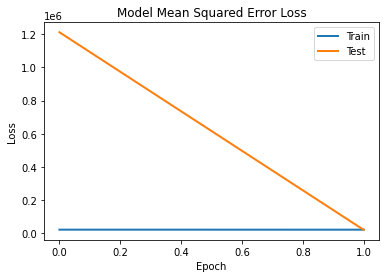

In [20]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Mean Squared Error Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [21]:
# n = np.random.randint(0,len(y_test))
preds = vae_latent.predict(test_set)
pred = vae_2.predict(test_set)

c:\Users\Saaqib\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


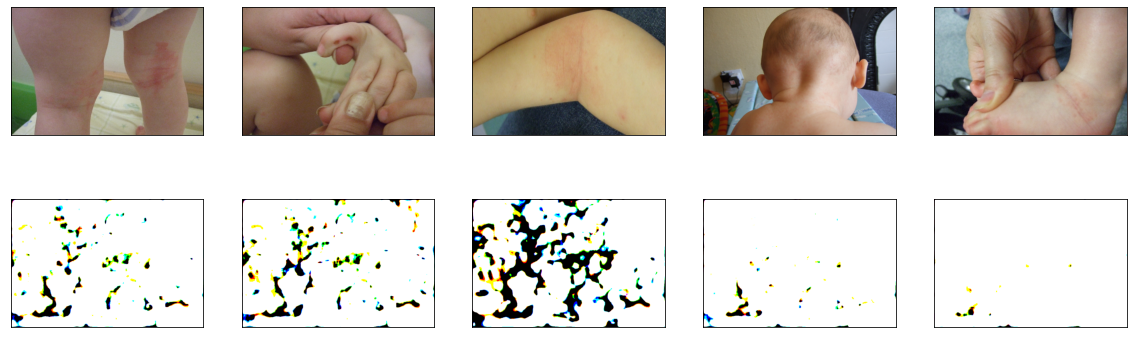

In [24]:
plt.figure(figsize=(20, 10))
for i in range(5):
    # Display original
    ax = plt.subplot(3, 5, i + 1)
    # plt.imshow(cv2.cvtColor(test_set[i].astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.imshow(test_set[i])
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display latent space
    # ax = plt.subplot(3,5, i+1+5)    
    # plt.imshow(cv2.cvtColor(preds[i,:,:,i].astype('uint8'), cv2.COLOR_RGB2BGR))
    # # plt.imshow(preds[i,:,:,i])
    # # img = Image.fromarray(cv2.cvtColor(preds[i,:,:,i].astype('uint8'), cv2.COLOR_BGR2RGB), 'RGB')
    # # plt.imshow(img.convert('RGB'))
    # ax.get_xaxis().set_visible(False)
    # ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(cv2.cvtColor(pred[i].astype('uint8'), cv2.COLOR_BGR2RGB))
    # plt.imshow(pred[i])
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
# issue is that 256,256 produces more of a latent represnatation than the higher image size

In [ ]:

# n = np.random.randint(0,len(y_test))
# preds = vae_latent.predict(y_test)
# pred = vae_2.predict(y_test)

# xtestdata = []
# latentspacedata = []
# preddata = []
# for i in range(5):
#     xtestdata.append(x_test[i])
#     latentspacedata.append(preds[i])
#     preddata.append(pred[i])

# print('xtestdata=',xtestdata)
# print('latentspacedata=',latentspacedata)
# print('preddata=',preddata)

In [ ]:
# n = np.random.randint(0,len(y_test))

# preds = model_latent.predict(y_test[n:n+4])

# f, ax = plt.subplots(2,2)
# ax = ax.ravel()
# for j in range(4):
#     for i,a in enumerate(range(n,n+3)):
#         ax[j].imshow(preds[i, :, :, j])
# plt.show()


In [ ]:
# pred = vae_2.predict(x_test)
# plt.figure(figsize=(20, 4))
# for i in range(5):
#     # Display original
#     ax = plt.subplot(2, 5, i + 1)
#     plt.imshow(x_test[i].reshape(2816,2048))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     # Display reconstruction
#     ax = plt.subplot(2, 5, i + 1 + 5)
#     plt.imshow(pred[i].reshape(2816,2048))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

In [ ]:
# x_test = []
# inpp = []
# for i in range(len(img_path)):
#     inp = get_input(img_path[i])
#     inp = preprocess_input(inp)
#     inp = cv2.resize(inp, (178,218))
#     inpp.append(inp)
#     # plt.imshow(inp)
# for i in range(len(inpp)):
#     x_test.append(inpp[random.randint(0,46)])
# x_test = np.array(x_test)
# figure_Decoded = vae_2.predict(x_test.astype('float32')/127.5 -1, batch_size = b_size)
# figure_original = x_test[0]
# figure_decoded = (figure_Decoded[0]+1)/2
# for i in range(4):
#     plt.axis('off')
#     plt.subplot(2,4,1+i*2)
#     plt.imshow(x_test[i])
#     plt.axis('off')
#     plt.subplot(2,4,2 + i*2)
#     plt.imshow((figure_Decoded[i]+1)/2)
#     plt.axis('off')
# plt.show()  